# Identifying Covid-19 using Chest X-ray with Deep Transfer Learning

In [19]:
# we will need these as we are using transfer learning and we will have to train our own last layer(s)
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Sequential, Model, load_model

# importing pre-trained modeland a fuction to pre-process our image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# we can change the above line of code to use any other pretrained model
# for example we can import DenseNet201
# from keras.applications.densenet import DenseNet201, preprocess_input

# for image data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
# usual imports
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

### Datasets
Covid-19 X-ray:
https://github.com/ieee8023/covid-chestxray-dataset  
Pneumonia and Normal X-ray:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [21]:
train_path = "/content/drive/MyDrive/Colab Notebooks/CNN/covid19_x_ray/Datasets/Train"
valid_path = "/content/drive/MyDrive/Colab Notebooks/CNN/covid19_x_ray/Datasets/Val"
test_path = "/content/drive/MyDrive/Colab Notebooks/CNN/covid19_x_ray/Datasets/Test"

In [22]:
#useful for getting number of classes
folders = glob("/content/drive/MyDrive/Colab Notebooks/CNN/covid19_x_ray/Datasets/Train/*")
folders

['/content/drive/MyDrive/Colab Notebooks/CNN/covid19_x_ray/Datasets/Train/COVID',
 '/content/drive/MyDrive/Colab Notebooks/CNN/covid19_x_ray/Datasets/Train/NORMAL']

### Downloading the pretrained VGG16 model with weights trained for ImageNet:

More Info.: https://keras.io/api/applications/

In [23]:
#resize all the images to this
image_size = [224, 224]

In [24]:
# we will not include last layer include_top=False
vgg = VGG16(input_shape=image_size+[3], weights="imagenet", include_top=False)

In [25]:
# we will not include last layer include_top=False
# example with DenseNet201
# densenet = DenseNet201(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE + [3], classes=1000)

In [26]:
#don't train existing weights
for layer in vgg.layers:
    layer.trainable=False

### Model Construction

In [27]:
#our layers
x = Flatten()(vgg.output)
# we can add more layers
# x = Dense(1000, activation="relu")(x)

In [28]:
prediction = Dense(len(folders), activation="softmax")(x)

In [29]:
#create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [30]:
#view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [31]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [32]:
#image_data_augmentation
train_datagen = ImageDataGenerator(rescale=1/255, shear_range=0.2,
                            zoom_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255, shear_range=0.2,
                            zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255)

training_set = train_datagen.flow_from_directory(train_path, batch_size=32,
                                                 target_size=(224, 224), class_mode="categorical")

validation_set = val_datagen.flow_from_directory(valid_path, batch_size=32,
                                                 target_size=(224, 224), class_mode="categorical")

test_set = test_datagen.flow_from_directory(test_path, batch_size=32,
                                                 target_size=(224, 224), class_mode="categorical")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [34]:
# fit the model
r = model.fit(training_set, validation_data=validation_set, epochs=5,
                        steps_per_epoch=len(training_set), validation_steps=len(validation_set))

Epoch 1/5
163/163 [==============================] - 1086s 7s/step - loss: 0.1759 - accuracy: 0.9277 - val_loss: 0.7930 - val_accuracy: 0.6875
Epoch 2/5
163/163 [==============================] - 111s 681ms/step - loss: 0.1143 - accuracy: 0.9546 - val_loss: 0.5372 - val_accuracy: 0.6875
Epoch 3/5
163/163 [==============================] - 108s 660ms/step - loss: 0.1075 - accuracy: 0.9634 - val_loss: 1.4689 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 107s 654ms/step - loss: 0.0962 - accuracy: 0.9640 - val_loss: 0.1102 - val_accuracy: 0.9375
Epoch 5/5
163/163 [==============================] - 107s 656ms/step - loss: 0.0758 - accuracy: 0.9714 - val_loss: 1.5386 - val_accuracy: 0.7500


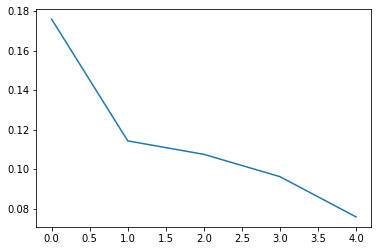

In [35]:
#loss_plot
plt.plot(r.history["loss"], label="Training Loss")

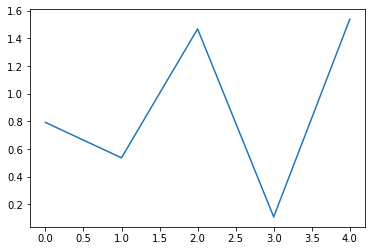

In [36]:
#loss_plot
plt.plot(r.history["val_loss"], label="Validation Loss")

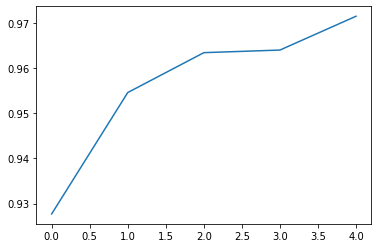

In [37]:
#accuracy_plot
plt.plot(r.history["accuracy"], label="Training Accuracy")

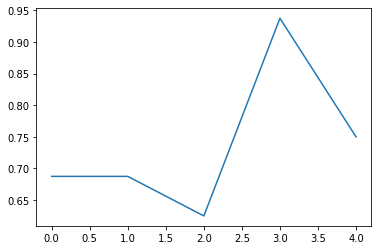

In [38]:
#accuracy_plot
plt.plot(r.history["val_accuracy"], label="Validation Accuracy")

In [41]:
scores = model.evaluate(test_set)
print(f"\n{model.metrics_names[1]}: {scores[1]*100:.2f}%")

20/20 [==============================] - 128s 7s/step - loss: 0.4110 - accuracy: 0.8878

accuracy: 88.78%


In [42]:
model.save("covid_model.h5")